In [409]:
from __future__ import division
from matplotlib import pyplot as plt
import numpy as np, random, time
from IPython import display
from matplotlib import colors
import copy
import scipy.optimize

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [153]:
def ising_energy(init):
    '''
    Computes the energy of a 2D square lattice in the Ising model
    '''
    
    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    
    energy = 0
    
    for i in range(Y):
        for j in range(X):
            energy += -1*init[i,j] * \
                (init[(i+1) % Y ,j] + init[(i-1) % Y,j] 
                 + init[i,(j+1) % X] + init[i,(j-1) % X])
            
    energy = energy/2
    
    return energy


def get_clustered_spins_to_flip(flattened_grid, s, neighboring_iis, cluster_prob):
    '''
    builds up a link of points to eventually cluster and then add spins
    to cluster with probability cluster_prob
    
    the link starts from point s; for each neighbor 'n' of each point in the link 
    'l', if the spins are the same, the neighbor isn't already in the cluster, 
    and p <= flip_prob, then the point is added to the link and the cluster, after 
    which the original point 'l' is removed from the link
    
    eventually, all the points in the links are exhausted and there are no more 
    points left to explore in the link. at this point, the points in the cluster 
    are returned.
    
    adapted from the pseudocode in https://arxiv.org/pdf/cond-mat/0311623v1.pdf
    '''
    link = np.zeros_like(flattened_grid)
    link[s] = 1
    cluster_iis = np.zeros_like(flattened_grid)
    cluster_iis[s] = 1
    
    while link.sum() > 0:
        l = np.random.choice([x for x in range(len(link)) if link[x]==1])
        for n in neighboring_iis[l]:
            if (flattened_grid[n] == flattened_grid[l] and cluster_iis[n] != 1 
                and np.random.rand() <= cluster_prob):
                link[n] = 1
                cluster_iis[n] = 1
        link[l] = 0
    
    return np.where(cluster_iis==1)[0]


def plot_ising_grid(init, ax=None, title=''):
    '''
    creates a discrete colormap for an input Ising grid
    red for up (1) and blue for down (-1)
    '''
    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    
    cmap = colors.ListedColormap(['black', 'white'])
    bounds = [0,1,1]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    if ax==None:
        fig, ax = plt.subplots(figsize=(8,8))
        plt.imshow(init, cmap=cmap, norm=norm)
        plt.title(title, fontsize=20)
        ax.tick_params(axis='x', which='both', bottom=False, top=False, 
                       labelbottom=False)
        ax.tick_params(axis='y', which='both', left=False, right=False, 
                       labelleft=False)

        display.clear_output(wait = True)

        plt.show()
    else:
        ax.imshow(init, cmap=cmap, norm=norm)


def wolff(init, L, J, T, nsteps):
    '''
    applies the wolff clustering algorithm to this ising state
    
    the grid is treated as a flattened 1D array, after which the neighboring indexes
    are found directly above, below, or next to the point in question (wrapped around)
    
    neighboring indexes format: 
     {index: [neighbor to the "left", neighbor to the "right", 
              neighbor "below", neighbor "above"]}
    '''
    N = L * L
    cluster_prob = 1-np.exp(-2*J/T)

    neighboring_iis = {i : [(i//L)*L + (i-1)%L, (i//L)*L + (i+1)%L,
                            (i+L)%N, (i-L)%N] for i in range(N)}

    grid = init[:]
    flattened_grid = grid.reshape([N])
    for i in range(nsteps):
        # choose a random spin index s in the grid
        s = np.random.randint(N) 
        cluster_iis = get_clustered_spins_to_flip(flattened_grid, s, neighboring_iis, 
                                                  cluster_prob)

        # after above process is done, flip the spins in the cluster
        flattened_grid[cluster_iis] *= -1

        # plot the updated wolff grid
#         plot_ising_grid(flattened_grid.reshape([L,L]))
    return grid

In [476]:
def spec_heat_ps(energy_list, T, N):
    """Compute the specific heat per spin for an input list of energy values at 
    temperature T and lattice sites N"""
    
    if type(energy_list) is list:
        energy_list = np.array(energy_list)
    
    c = (1/(T**2 * N)) * np.var(energy_list)
    
    return c


def sus(mag_list, T, N):
    """Compute susceptibility for an input list of magnetization values at 
    temperature T and lattice sites N"""
    
    if type(mag_list) is list:
        mag_list = np.array(mag_list)
    
    chi = (1/(T*N)) * np.var(mag_list)
    
    return chi


def bootstrap_mean(values_list, n):
    """Uses the bootstrap method to compute the error in the mean of a given list 
    of values"""
    
    values = copy.copy(values_list)
    ns = len(values)
    
    means = []
    
    for i in range(n):
        samples = np.random.choice(values, ns)
        means.append(np.mean(samples))
    
    error = np.std(means)
    
    return error


def bootstrap_c(energies, T, N, n):
    """Uses bootstrap to compute the error in the specific heat for an input set of 
    energies"""
    
    e_list = copy.copy(energies)
    ns = len(e_list)
    
    values = []
    
    for i in range(n):
        samples = np.random.choice(e_list, ns)
        values.append(spec_heat_ps(samples, T, N))
        
    error = np.std(values)
    
    return error


def bootstrap_s(magps, T, N, n):
    """Uses bootstrap to compute the error in the susceptibility for an input set of 
    magnetization"""
    
    mps_list = [i for i in magps]
    ns = len(mps_list)
    
    values = []
    
    for i in range(n):
        samples = np.random.choice(mps_list, ns)
        values.append(sus(mps_list, T, N))
    
    error = np.std(values)
    
    return error

***

## Checking evolution

In [73]:
T = 2.2
J = 1
L = 5
nsteps = 10
init = np.reshape([random.choice([1, -1]) for k in range(L*L)], (L,L))
%time grid = wolff(init, L, J, T, nsteps)

CPU times: user 9.27 ms, sys: 2.82 ms, total: 12.1 ms
Wall time: 12.9 ms


n: 0
n: 1
n: 5
n: 10
n: 20
n: 50
n: 100
n: 500
n: 1000


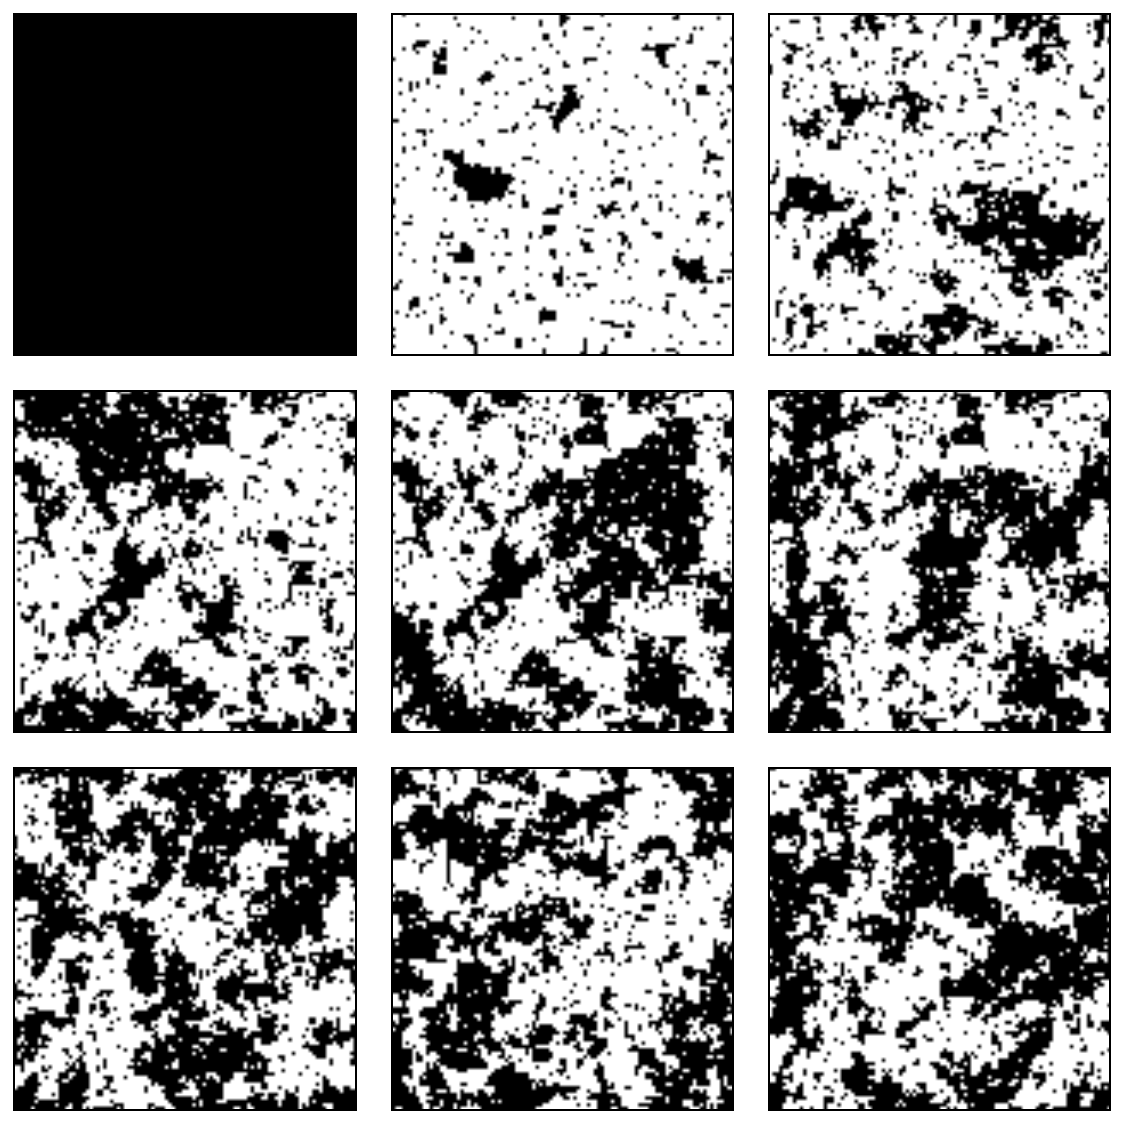

In [191]:
T = 2.4
J = 1
L = 100
init = np.ones((L,L))

f, axarr = plt.subplots(3,3)
f.set_size_inches(8,8)
plt.tight_layout(pad=0, w_pad=-1, h_pad=-1)
axes = np.ndarray.flatten(axarr)
grid = np.copy(init)
ax_counter = 0
for n in range(1000+1):
    if n in [0, 1, 5, 10, 20, 50, 100, 500, 1000]:
        print 'n:', n
        plot_ising_grid(-grid, axes[ax_counter])
        axes[ax_counter].tick_params(axis='x', which='both', bottom=False, 
                                     top=False, labelbottom=False)
        axes[ax_counter].tick_params(axis='y', which='both', left=False, 
                                     'right=False, labelleft=False)
        ax_counter += 1
    grid = wolff(grid, L, J, T, 1)
    
plt.savefig('Report/Wolff_evolution.pdf', bbox_inches='tight')

***

## Checking equilibration time

In [360]:
L=20
# grid = np.ones((L,L))
grid = np.random.rand(*(L,L))

T=2.7
nsteps = 1000 #200 * L**2
HH = np.zeros(nsteps)
MM = np.zeros(nsteps)
for nn in range(nsteps):
    if nn%100==0: print 'index',nn
    grid = wolff(grid, L, J, T, 5)
    HH[nn] = ising_energy(grid)
    MM[nn] = np.sum(grid)

index 0
index 100
index 200
index 300
index 400
index 500
index 600
index 700
index 800
index 900


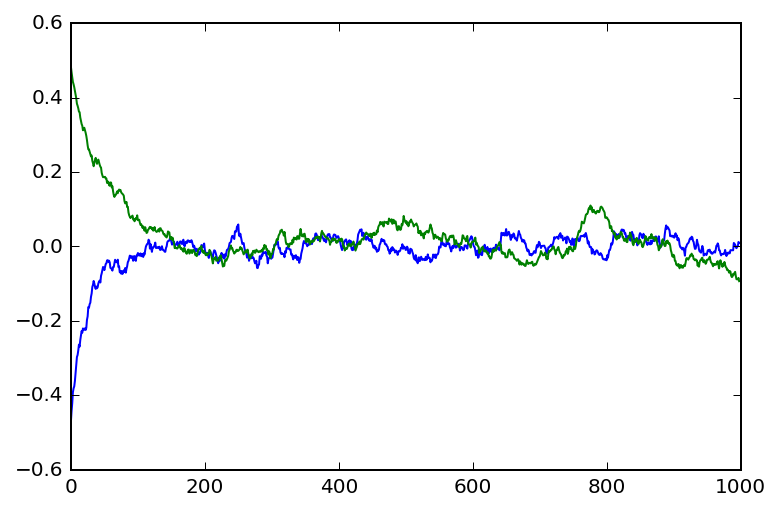

In [361]:
plt.plot(range(nsteps)[:nn], np.array(HH[:nn])/L**2)
plt.plot(range(nsteps)[:nn], np.array(MM[:nn])/L**2)

***

# Taking measurements

### L = 10

In [311]:
J = 1
L = 10

temps = np.arange(1.6, 2.91, .01)

# initialize to T = 0
test = 1*np.ones((L,L))      

# rough estimate for equilibration time; 10*L many sweeps
n_eq = L #10*L

# number of sweeps to average over
n = 5*L

# factors for averaging
n1 = 1.0/(n * L**2)
n2 = 1.0/(n**2 * L**2)

In [312]:
start = time.time()

# initialize lists
eneps_list10 = np.zeros(len(temps))
magps_list10 = np.zeros(len(temps))
spec_heat10 = np.zeros(len(temps))
mag_sus10 = np.zeros(len(temps))

# these dicts correspond to temps for err purposes
e_total_dict = {}
e2_total_dict = {}
mag_total_dict = {}
mag2_total_dict = {}

grid = np.copy(test)

for i in range(len(temps)):
#     if i%5==0: 
    print 'T num =', i
    T = temps[i]
    
    # force the grid to equilibrate at ea. T
#     for j in range(n_eq):
    grid = wolff(grid, L, J, T, n_eq)
    
    # initialize the totals that will be used to compute averages
    e_total = 0
    e2_total = 0
    mag_total = 0
    mag2_total = 0
    
    # temp lists for err purposes
    e_total_temp = np.zeros(n)
    e2_total_temp = np.zeros(n)
    mag_total_temp = np.zeros(n)
    mag2_total_temp = np.zeros(n)

    # measurements to average
    for k in range(n):
        energy = ising_energy(grid) 
        mag = np.sum(grid)
        
        e_total += energy
        e2_total += energy*energy
        mag_total += np.abs(mag)
        mag2_total += mag*mag
        
        e_total_temp[k] = energy
        e2_total_temp[k] = energy*energy
        mag_total_temp[k] = np.abs(mag)
        mag2_total_temp[k] = mag*mag
        
        grid = wolff(grid, L, J, T, 5)

    
    # add to lists for err purposes
    e_total_dict[i] = e_total_temp
    e2_total_dict[i] = e2_total_temp
    mag_total_dict[i] = mag_total_temp
    mag2_total_dict[i] = mag2_total_temp
    
    # compute averages
    eneps_list10[i] = n1*e_total
    magps_list10[i] = n1*mag_total
    spec_heat10[i] = (n1*e2_total - n2*e_total*e_total)/(T*T)
    mag_sus10[i] = (n1*mag2_total - n2*mag_total*mag_total)/T
        
        
end = time.time()
print end - start

np.savez('Wolff_Observables_10', temps=temps, energy_per_spin=eneps_list10, 
         specific_heat_per_spin=spec_heat10, 
         magnetization_per_spin=magps_list10, 
         magnetic_susceptibility=mag_sus10)

T num = 0
T num = 1
T num = 2
T num = 3
T num = 4
T num = 5
T num = 6
T num = 7
T num = 8
T num = 9
T num = 10
T num = 11
T num = 12
T num = 13
T num = 14
T num = 15
T num = 16
T num = 17
T num = 18
T num = 19
T num = 20
T num = 21
T num = 22
T num = 23
T num = 24
T num = 25
T num = 26
T num = 27
T num = 28
T num = 29
T num = 30
T num = 31
T num = 32
T num = 33
T num = 34
T num = 35
T num = 36
T num = 37
T num = 38
T num = 39
T num = 40
T num = 41
T num = 42
T num = 43
T num = 44
T num = 45
T num = 46
T num = 47
T num = 48
T num = 49
T num = 50
T num = 51
T num = 52
T num = 53
T num = 54
T num = 55
T num = 56
T num = 57
T num = 58
T num = 59
T num = 60
T num = 61
T num = 62
T num = 63
T num = 64
T num = 65
T num = 66
T num = 67
T num = 68
T num = 69
T num = 70
T num = 71
T num = 72
T num = 73
T num = 74
T num = 75
T num = 76
T num = 77
T num = 78
T num = 79
T num = 80
T num = 81
T num = 82
T num = 83
T num = 84
T num = 85
T num = 86
T num = 87
T num = 88
T num = 89
T num = 90
T num = 9

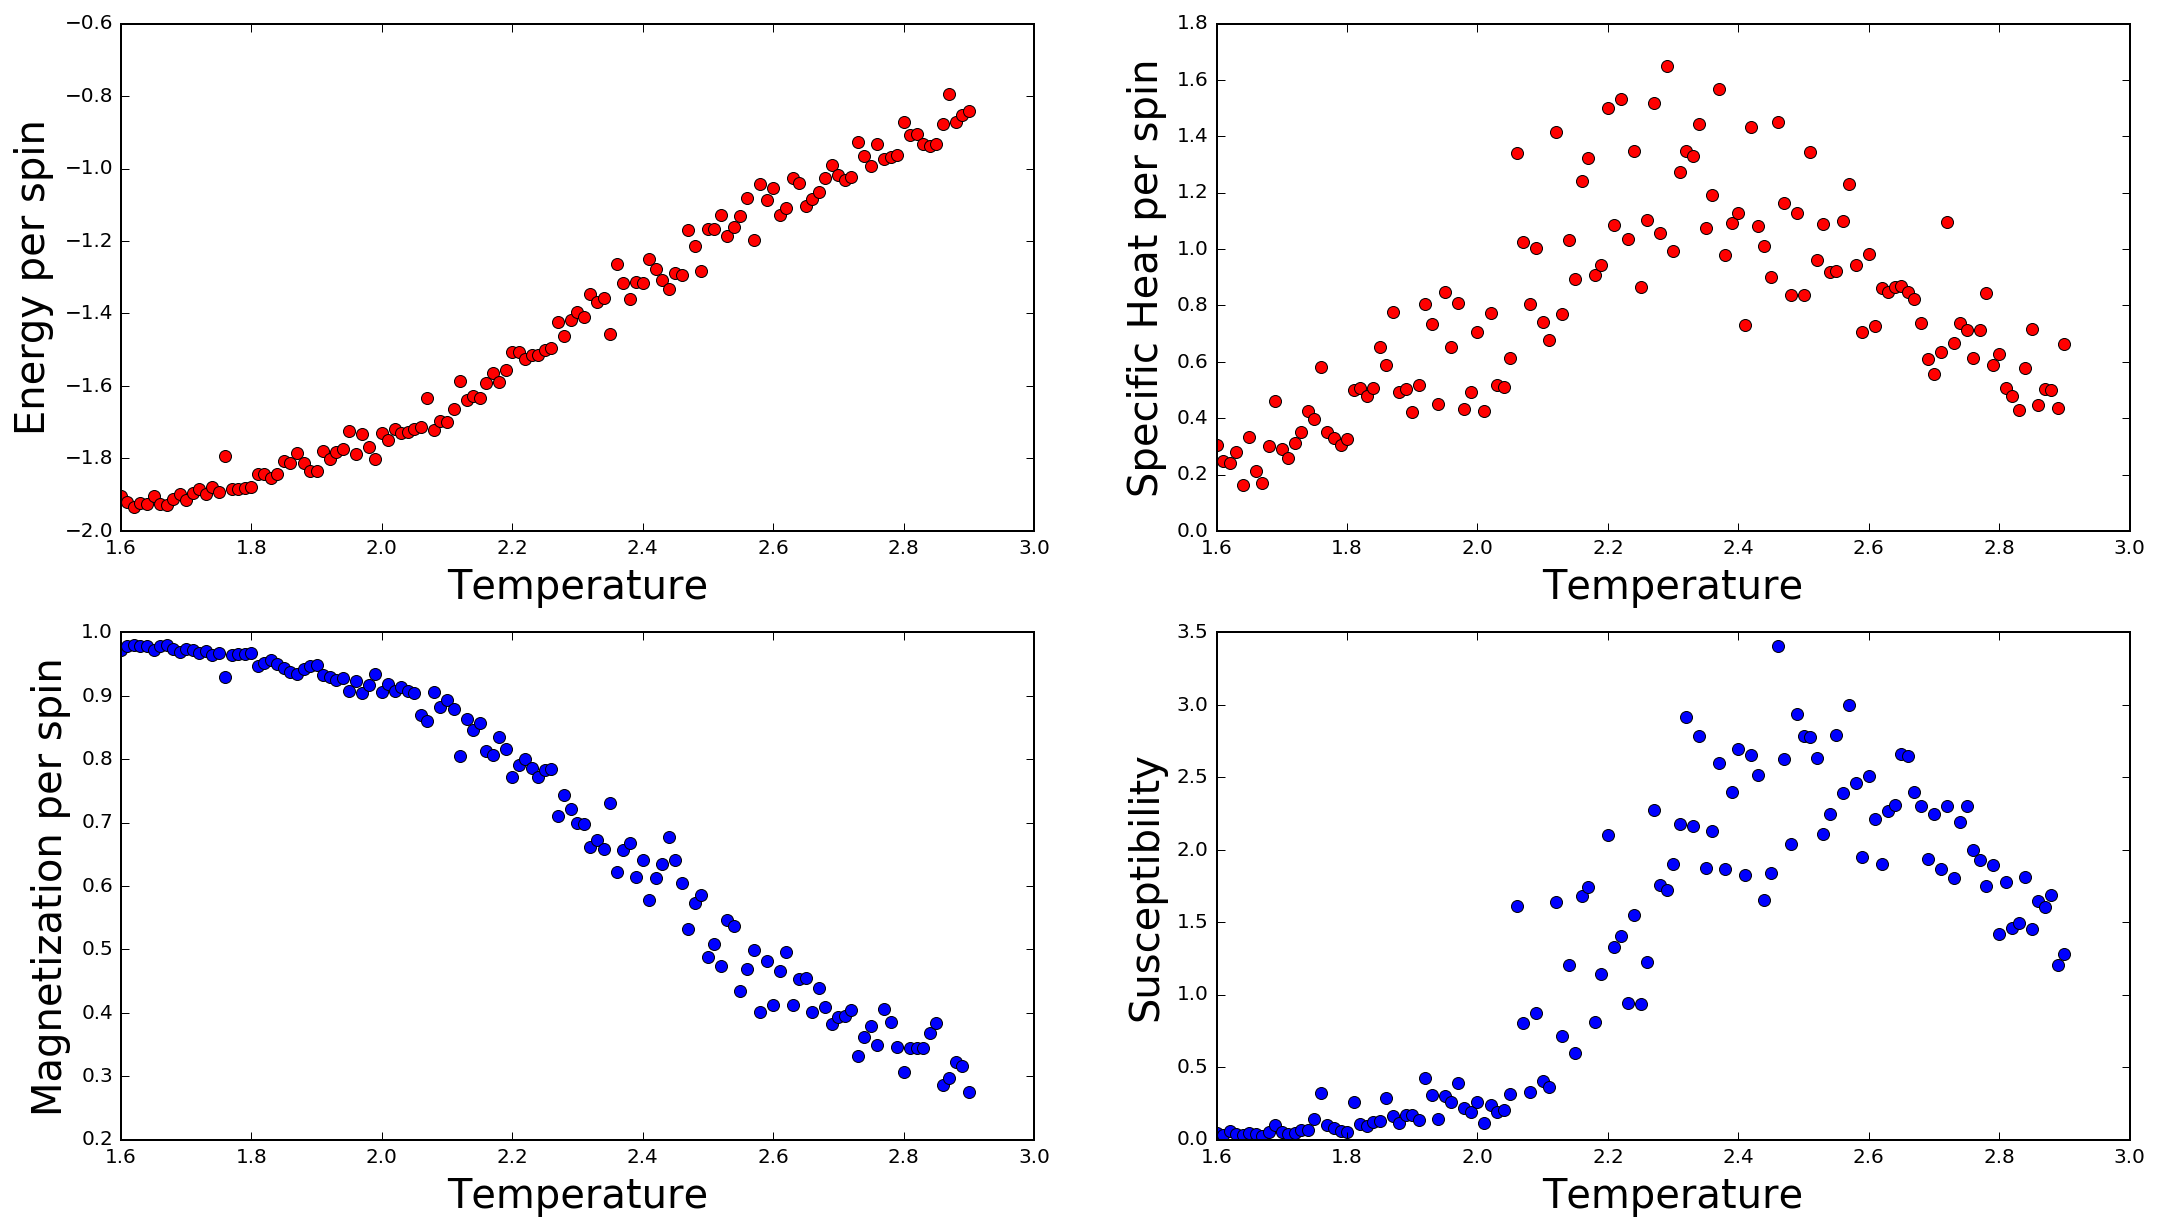

In [313]:
fig = plt.figure(figsize=(18, 10)) # plot the calculated values    

fig.add_subplot(2, 2, 1 )
plt.plot(temps, eneps_list10, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Energy per spin", fontsize=20)

fig.add_subplot(2, 2, 2 )
plt.plot(temps, spec_heat10, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Specific Heat per spin", fontsize=20)

fig.add_subplot(2, 2, 3 )
plt.plot(temps, magps_list10, 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Magnetization per spin", fontsize=20)

fig.add_subplot(2, 2, 4 )
plt.plot(temps, mag_sus10, 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Susceptibility", fontsize=20)

plt.show()

### L = 20

In [102]:
# exploring the temperature range around the critical temp
temps = np.arange(1.6, 2.91, .01)

# initialize to T = 0
test = np.ones((L,L))      

# rough estimate for equilibration time; 1/L many sweeps
n_eq = L 

# number of sweeps to average over
n = 5*L

# factors for averaging
n1 = 1.0/(n * L**2)
n2 = 1.0/(n**2 * L**2)

In [103]:
start = time.time()

# initialize lists
eneps_list8 = np.zeros(len(temps))
magps_list8 = np.zeros(len(temps))
spec_heat8 = np.zeros(len(temps))
mag_sus8 = np.zeros(len(temps))

# these dicts correspond to temps for err purposes
e_total_dict = {}
e2_total_dict = {}
mag_total_dict = {}
mag2_total_dict = {}

grid = np.copy(test)

for i in range(len(temps)):
#     if i%5==0: 
    print 'T num =', i
    T = temps[i]
    
    # force the grid to equilibrate at ea. T
#     for j in range(n_eq):
    grid = wolff(grid, L, J, T, n_eq)
    
    # initialize the totals that will be used to compute averages
    e_total = 0
    e2_total = 0
    mag_total = 0
    mag2_total = 0
    
    # temp lists for err purposes
    e_total_temp = np.zeros(n)
    e2_total_temp = np.zeros(n)
    mag_total_temp = np.zeros(n)
    mag2_total_temp = np.zeros(n)

    # measurements to average
    for k in range(n):
        energy = ising_energy(grid) 
        mag = np.sum(grid)
        
        e_total += energy
        e2_total += energy*energy
        mag_total += np.abs(mag)
        mag2_total += mag*mag
        
        e_total_temp[k] = energy
        e2_total_temp[k] = energy*energy
        mag_total_temp[k] = np.abs(mag)
        mag2_total_temp[k] = mag*mag
        
        grid = wolff(grid, L, J, T, 5)

    
    # add to lists for err purposes
    e_total_dict[i] = e_total_temp
    e2_total_dict[i] = e2_total_temp
    mag_total_dict[i] = mag_total_temp
    mag2_total_dict[i] = mag2_total_temp
    
    # compute averages
    eneps_list8[i] = n1*e_total
    magps_list8[i] = n1*mag_total
    spec_heat8[i] = (n1*e2_total - n2*e_total*e_total)/(T*T)
    mag_sus8[i] = (n1*mag2_total - n2*mag_total*mag_total)/T
        
        
end = time.time()
print end - start

np.savez('Wolff_Observables', temps=temps, energy_per_spin=eneps_list8, 
         specific_heat_per_spin=spec_heat8, 
         magnetization_per_spin=magps_list8, 
         magnetic_susceptibility=mag_sus8)

T num = 0
T num = 1
T num = 2
T num = 3
T num = 4
T num = 5
T num = 6
T num = 7
T num = 8
T num = 9
T num = 10
T num = 11
T num = 12
T num = 13
T num = 14
T num = 15
T num = 16
T num = 17
T num = 18
T num = 19
T num = 20
T num = 21
T num = 22
T num = 23
T num = 24
T num = 25
T num = 26
T num = 27
T num = 28
T num = 29
T num = 30
T num = 31
T num = 32
T num = 33
T num = 34
T num = 35
T num = 36
T num = 37
T num = 38
T num = 39
T num = 40
T num = 41
T num = 42
T num = 43
T num = 44
T num = 45
T num = 46
T num = 47
T num = 48
T num = 49
T num = 50
T num = 51
T num = 52
T num = 53
T num = 54
T num = 55
T num = 56
T num = 57
T num = 58
T num = 59
T num = 60
T num = 61
T num = 62
T num = 63
T num = 64
T num = 65
T num = 66
T num = 67
T num = 68
T num = 69
T num = 70
T num = 71
T num = 72
T num = 73
T num = 74
T num = 75
T num = 76
T num = 77
T num = 78
T num = 79
T num = 80
T num = 81
T num = 82
T num = 83
T num = 84
T num = 85
T num = 86
T num = 87
T num = 88
T num = 89
T num = 90
T num = 9

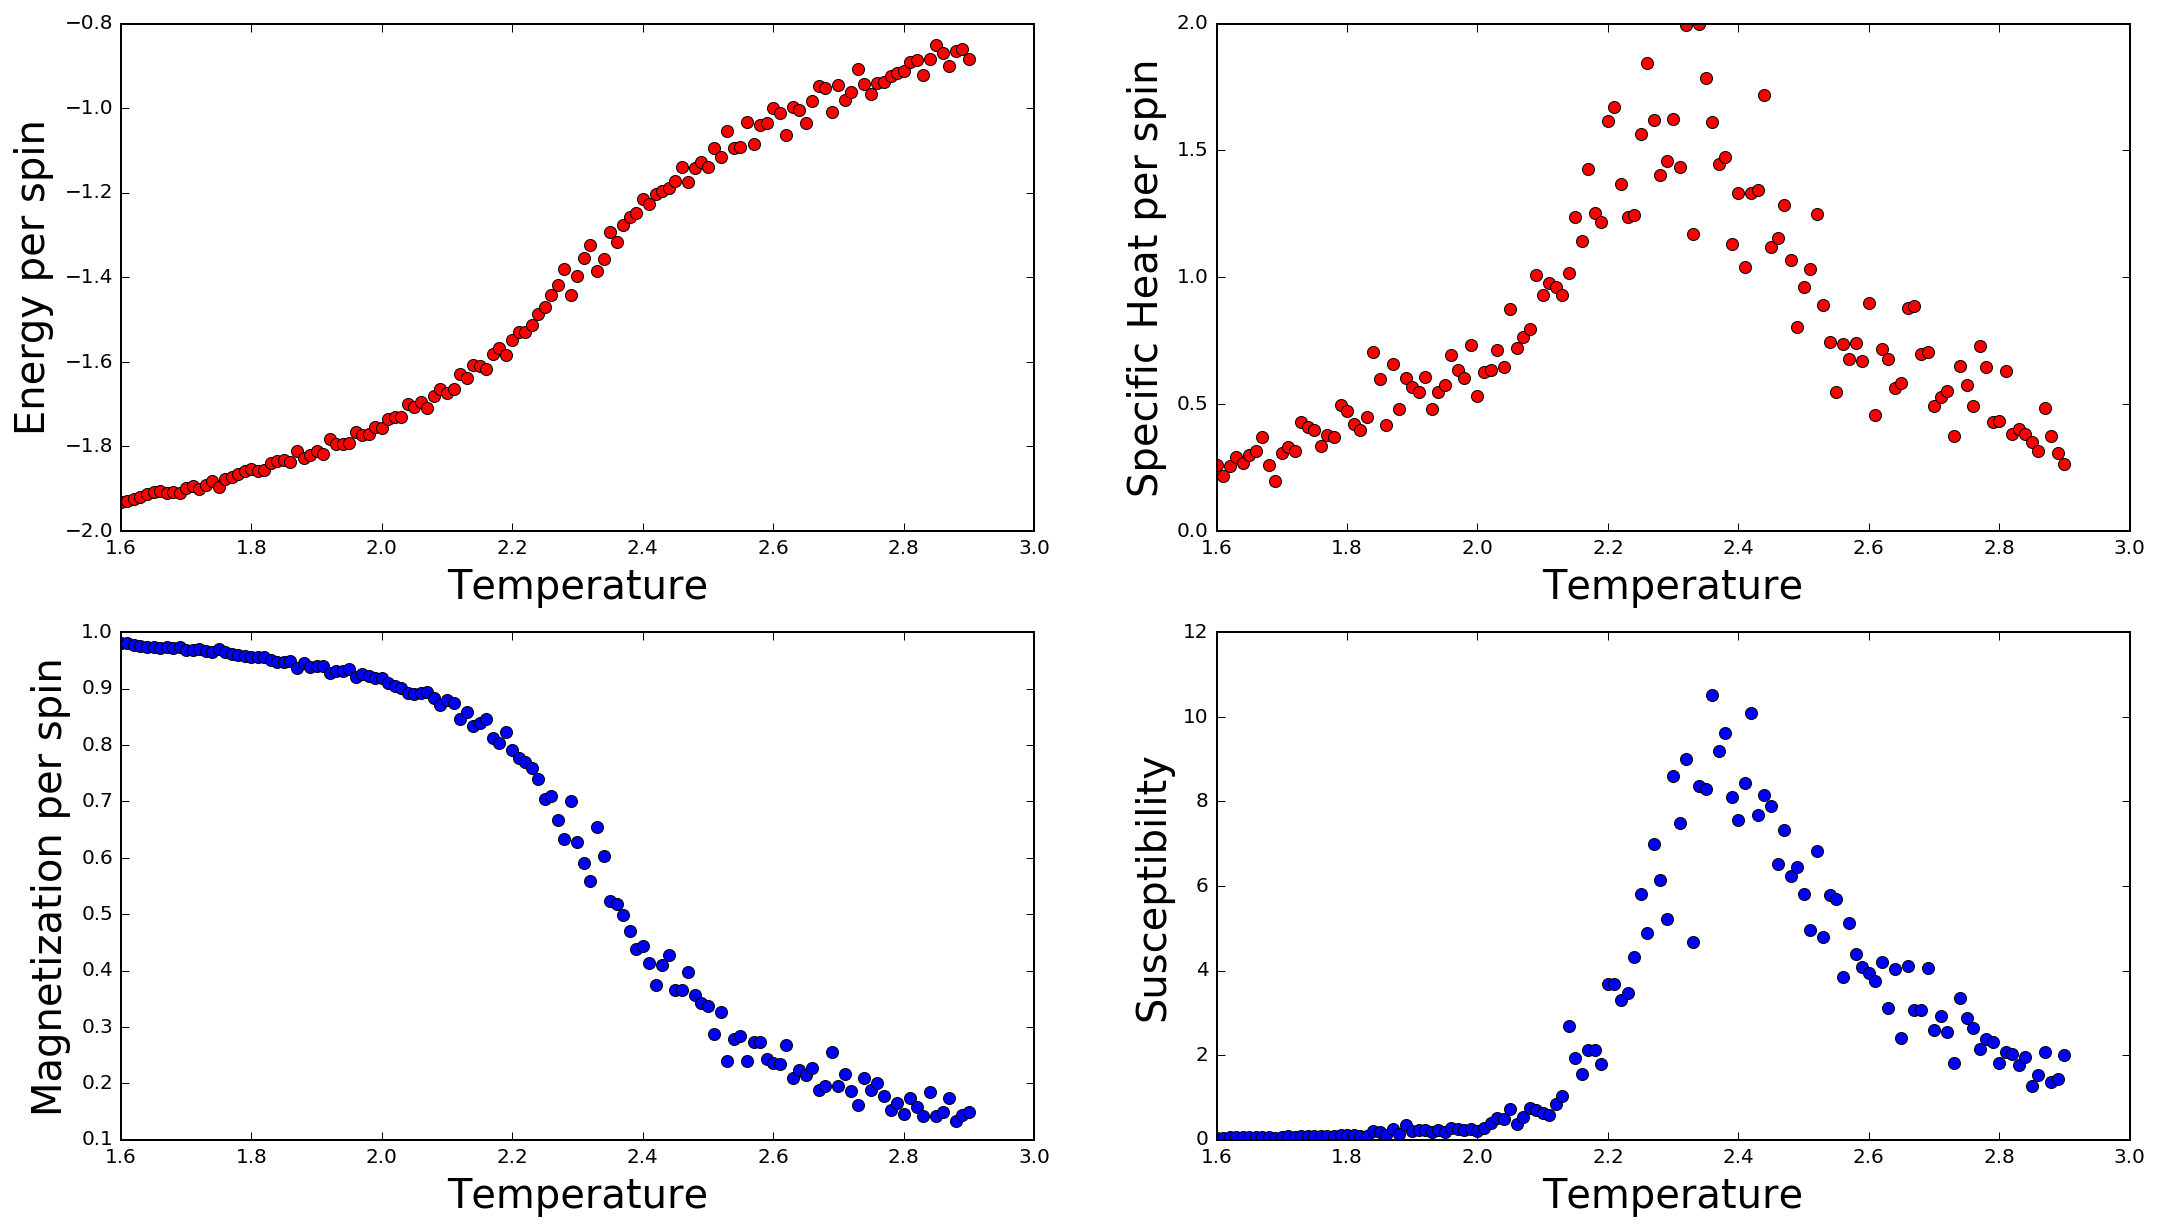

In [104]:
fig = plt.figure(figsize=(18, 10)) # plot the calculated values    

fig.add_subplot(2, 2, 1 )
plt.plot(temps, eneps_list8, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Energy per spin", fontsize=20)

fig.add_subplot(2, 2, 2 )
plt.plot(temps, spec_heat8, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Specific Heat per spin", fontsize=20)

fig.add_subplot(2, 2, 3 )
plt.plot(temps, magps_list8, 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Magnetization per spin", fontsize=20)

fig.add_subplot(2, 2, 4 )
plt.plot(temps, mag_sus8, 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Susceptibility", fontsize=20)

plt.show()

## L = 30

In [314]:
J = 1
L = 30

temps = np.arange(1.6, 2.91, .01)

# initialize to T = 0
test = 1*np.ones((L,L))      

# rough estimate for equilibration time; 10*L many sweeps
n_eq = L #10*L

# number of sweeps to average over
n = 5*L

# factors for averaging
n1 = 1.0/(n * L**2)
n2 = 1.0/(n**2 * L**2)

In [315]:
start = time.time()

# initialize lists
eneps_list30 = np.zeros(len(temps))
magps_list30 = np.zeros(len(temps))
spec_heat30 = np.zeros(len(temps))
mag_sus30 = np.zeros(len(temps))

# these dicts correspond to temps for err purposes
e_total_dict = {}
e2_total_dict = {}
mag_total_dict = {}
mag2_total_dict = {}

grid = np.copy(test)

for i in range(len(temps)):
#     if i%5==0: 
    print 'T num =', i
    T = temps[i]
    
    # force the grid to equilibrate at ea. T
#     for j in range(n_eq):
    grid = wolff(grid, L, J, T, n_eq)
    
    # initialize the totals that will be used to compute averages
    e_total = 0
    e2_total = 0
    mag_total = 0
    mag2_total = 0
    
    # temp lists for err purposes
    e_total_temp = np.zeros(n)
    e2_total_temp = np.zeros(n)
    mag_total_temp = np.zeros(n)
    mag2_total_temp = np.zeros(n)

    # measurements to average
    for k in range(n):
        energy = ising_energy(grid)     
        mag = np.sum(grid)
        
        e_total += energy
        e2_total += energy*energy
        mag_total += np.abs(mag)
        mag2_total += mag*mag
        
        e_total_temp[k] = energy
        e2_total_temp[k] = energy*energy
        mag_total_temp[k] = np.abs(mag)
        mag2_total_temp[k] = mag*mag
        
        grid = wolff(grid, L, J, T, 5)

    
    # add to lists for err purposes
    e_total_dict[i] = e_total_temp
    e2_total_dict[i] = e2_total_temp
    mag_total_dict[i] = mag_total_temp
    mag2_total_dict[i] = mag2_total_temp
    
    # compute averages
    eneps_list30[i] = n1*e_total
    magps_list30[i] = n1*mag_total
    spec_heat30[i] = (n1*e2_total - n2*e_total*e_total)/(T*T)
    mag_sus30[i] = (n1*mag2_total - n2*mag_total*mag_total)/T
        
        
end = time.time()
print end - start

np.savez('Wolff_Observables_30', temps=temps, energy_per_spin=eneps_list30, 
         specific_heat_per_spin=spec_heat30, 
         magnetization_per_spin=magps_list30, 
         magnetic_susceptibility=mag_sus30)

np.savez('Wolff_Observables_Errs30', energy_per_spin_errs=e_total_dict, 
         specific_heat_per_spin_errs=e2_total_dict, 
         magnetization_per_spin_errs=mag_total_dict, 
         magnetic_susceptibility_errs=mag2_total_dict)

T num = 0
T num = 1
T num = 2
T num = 3
T num = 4
T num = 5
T num = 6
T num = 7
T num = 8
T num = 9
T num = 10
T num = 11
T num = 12
T num = 13
T num = 14
T num = 15
T num = 16
T num = 17
T num = 18
T num = 19
T num = 20
T num = 21
T num = 22
T num = 23
T num = 24
T num = 25
T num = 26
T num = 27
T num = 28
T num = 29
T num = 30
T num = 31
T num = 32
T num = 33
T num = 34
T num = 35
T num = 36
T num = 37
T num = 38
T num = 39
T num = 40
T num = 41
T num = 42
T num = 43
T num = 44
T num = 45
T num = 46
T num = 47
T num = 48
T num = 49
T num = 50
T num = 51
T num = 52
T num = 53
T num = 54
T num = 55
T num = 56
T num = 57
T num = 58
T num = 59
T num = 60
T num = 61
T num = 62
T num = 63
T num = 64
T num = 65
T num = 66
T num = 67
T num = 68
T num = 69
T num = 70
T num = 71
T num = 72
T num = 73
T num = 74
T num = 75
T num = 76
T num = 77
T num = 78
T num = 79
T num = 80
T num = 81
T num = 82
T num = 83
T num = 84
T num = 85
T num = 86
T num = 87
T num = 88
T num = 89
T num = 90
T num = 9

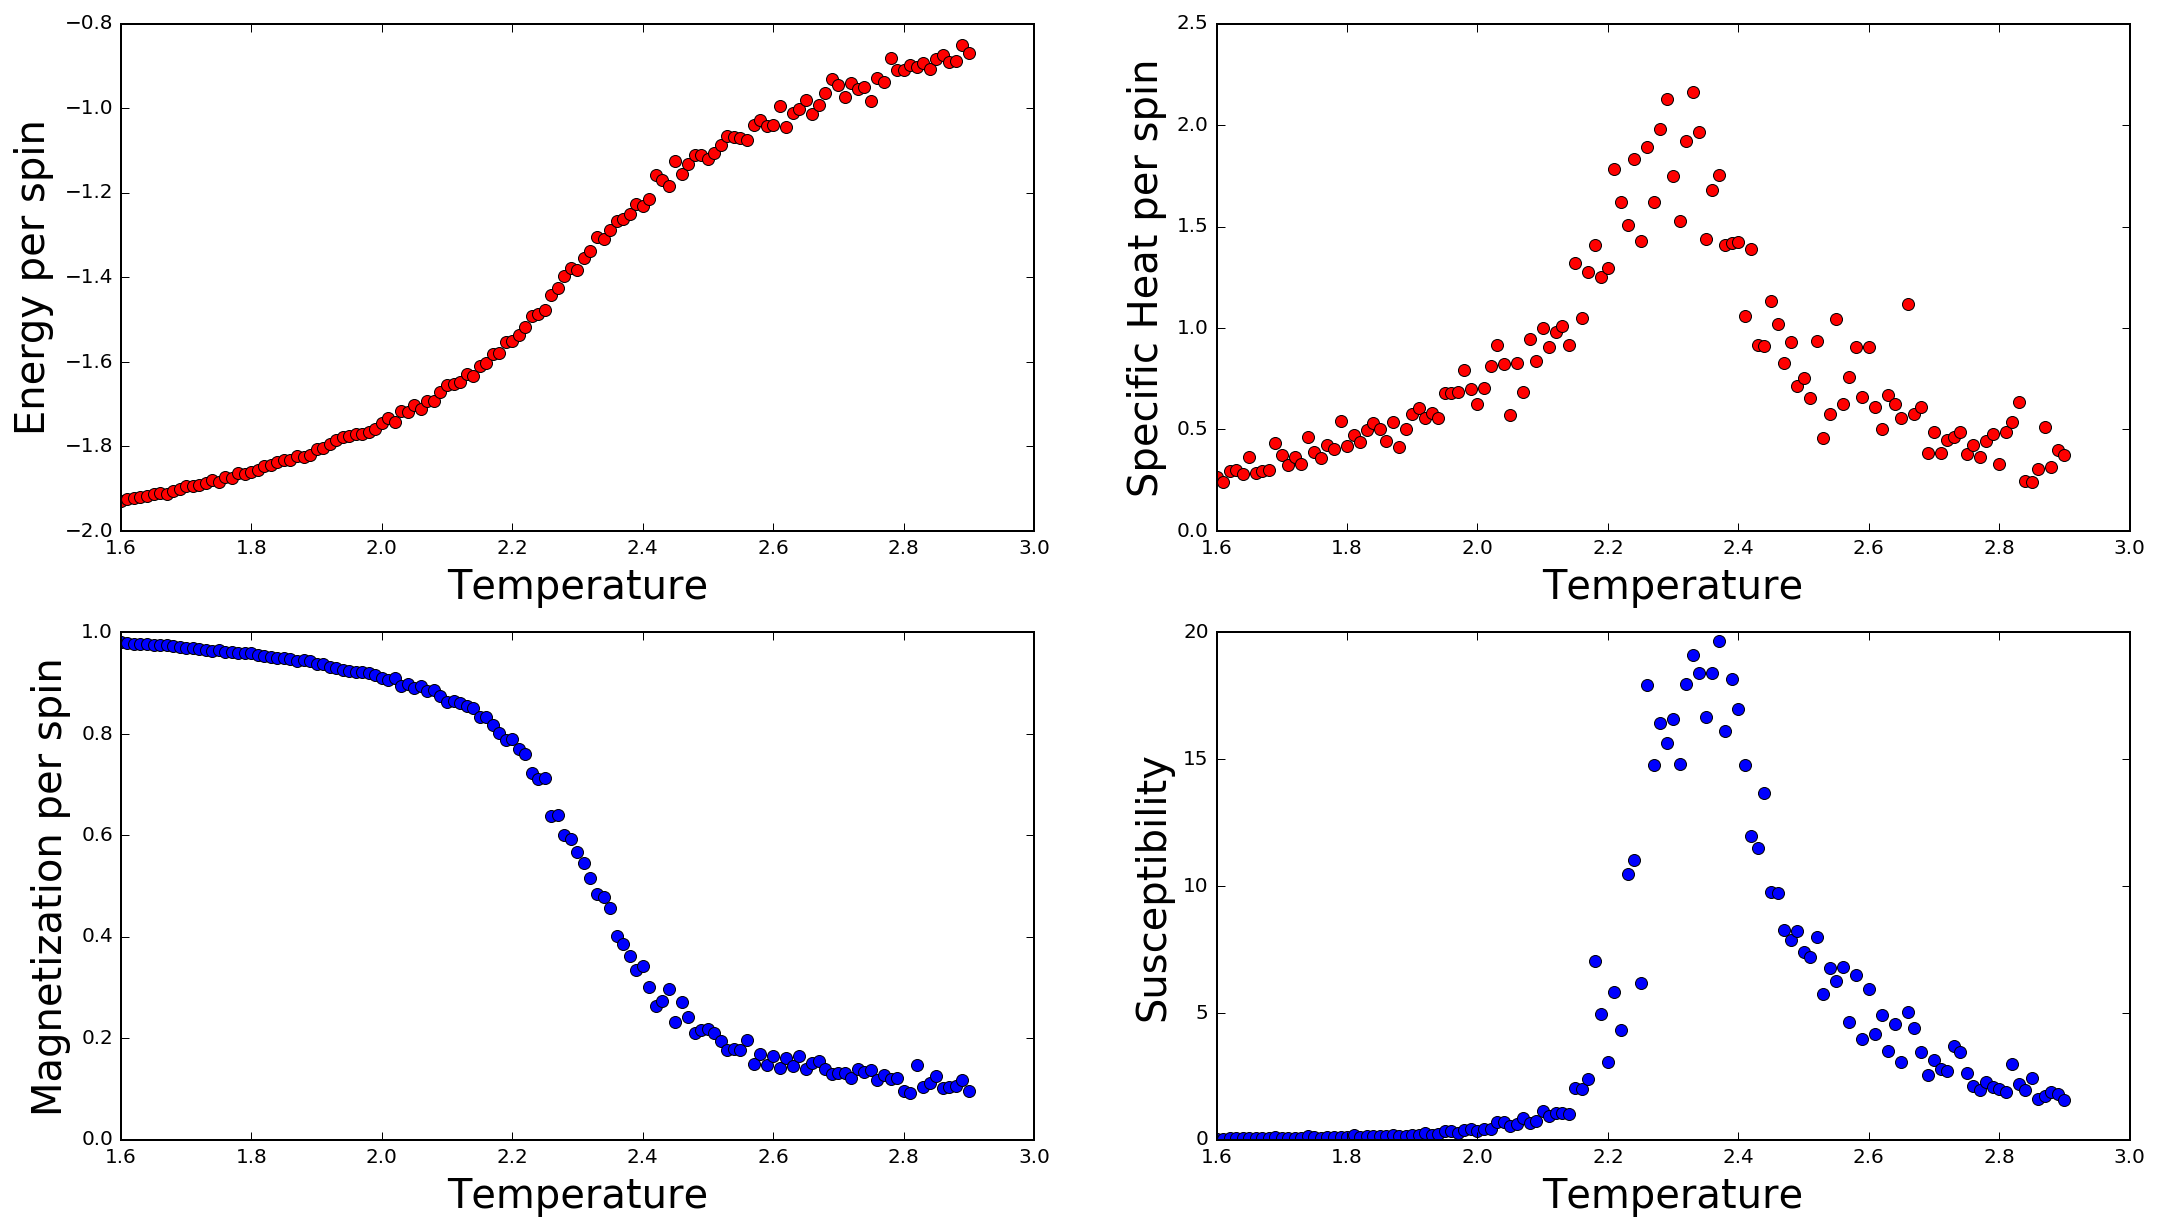

In [316]:
fig = plt.figure(figsize=(18, 10)) # plot the calculated values    

fig.add_subplot(2, 2, 1 )
plt.plot(temps, eneps_list30, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Energy per spin", fontsize=20)

fig.add_subplot(2, 2, 2 )
plt.plot(temps, spec_heat30, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Specific Heat per spin", fontsize=20)

fig.add_subplot(2, 2, 3 )
plt.plot(temps, magps_list30, 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Magnetization per spin", fontsize=20)

fig.add_subplot(2, 2, 4 )
plt.plot(temps, mag_sus30, 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Susceptibility", fontsize=20)

plt.savefig('Report/Wolff_Measurements.pdf')
plt.show()

***

# Exploring critical behavior

### computing errors

In [441]:
zz = np.load('Wolff_Observables_Errs30.npz')
e_total_dict=zz['energy_per_spin_errs'].item()
e2_total_dict=zz['specific_heat_per_spin_errs'].item()
mag_total_dict=zz['magnetization_per_spin_errs'].item()
mag2_total_dict=zz['magnetic_susceptibility_errs'].item()

keys = list(mag_total_dict.keys())

mag_errors = []
for k in keys:
    if k==0: continue
    mag_errors.append(bootstrap_mean(mag_total_dict[k], 1000))
print '---'
sus_errors = []
for k in keys:
    if k==0: continue
    sus_errors.append(bootstrap_s(mag2_total_dict[k], float(k), 625, 1000))
print '---'
sh_errors = []
for k in keys:
    if k==0: continue
    sh_errors.append(bootstrap_c(e2_total_dict[k], float(k), 625, 1000))
print '---'
# np.save('Potts_magerr', mag_errors)
# np.save('Potts_suserr', sus_errors)
# np.save('Potts_sherr', sh_errors)

---
---
---


In [508]:
sus_errors2 = np.array(copy.copy(sus_errors))
offset = min([x for x in sus_errors if x != 0])
zeros = np.array([x for x in range(len(sus_errors)) if sus_errors[x]==0], dtype=int)
sus_errors2[zeros] += offset
sus_errors2

array([  4.54747351e-13,   5.82076609e-11,   1.45519152e-11,
         1.45519152e-11,   4.36557457e-11,   7.27595761e-12,
         2.91038305e-11,   1.45519152e-11,   2.91038305e-11,
         2.18278728e-11,   4.54747351e-13,   7.27595761e-12,
         7.27595761e-12,   1.45519152e-11,   7.27595761e-12,
         1.45519152e-11,   7.27595761e-12,   7.27595761e-12,
         7.27595761e-12,   4.54747351e-13,   7.27595761e-12,
         1.45519152e-11,   4.54747351e-13,   7.27595761e-12,
         4.54747351e-13,   7.27595761e-12,   7.27595761e-12,
         4.54747351e-13,   4.54747351e-13,   7.27595761e-12,
         7.27595761e-12,   2.18278728e-11,   4.54747351e-13,
         1.45519152e-11,   2.91038305e-11,   4.54747351e-13,
         2.18278728e-11,   1.45519152e-11,   4.54747351e-13,
         1.45519152e-11,   4.54747351e-13,   1.45519152e-11,
         1.45519152e-11,   4.36557457e-11,   2.91038305e-11,
         4.54747351e-13,   1.45519152e-11,   2.91038305e-11,
         2.91038305e-11,

### computing exponents

In [287]:
def power(x, a, b, c):
    return a*((b-x)/b)**c

In [460]:
np.savez('Wolff_Observables_30', temps=temps, energy_per_spin=eneps_list30, 
         specific_heat_per_spin=spec_heat30, 
         magnetization_per_spin=magps_list30, 
         magnetic_susceptibility=mag_sus30)
zz = np.load('Wolff_Observables_30.npz')
temps = zz['temps'][1:]
eneps_list30 = zz['energy_per_spin'][1:]
spec_heat30 = zz['specific_heat_per_spin'][1:]
magps_list30 = zz['magnetization_per_spin'][1:]
mag_sus30 = zz['magnetic_susceptibility'][1:]

#### magnetization

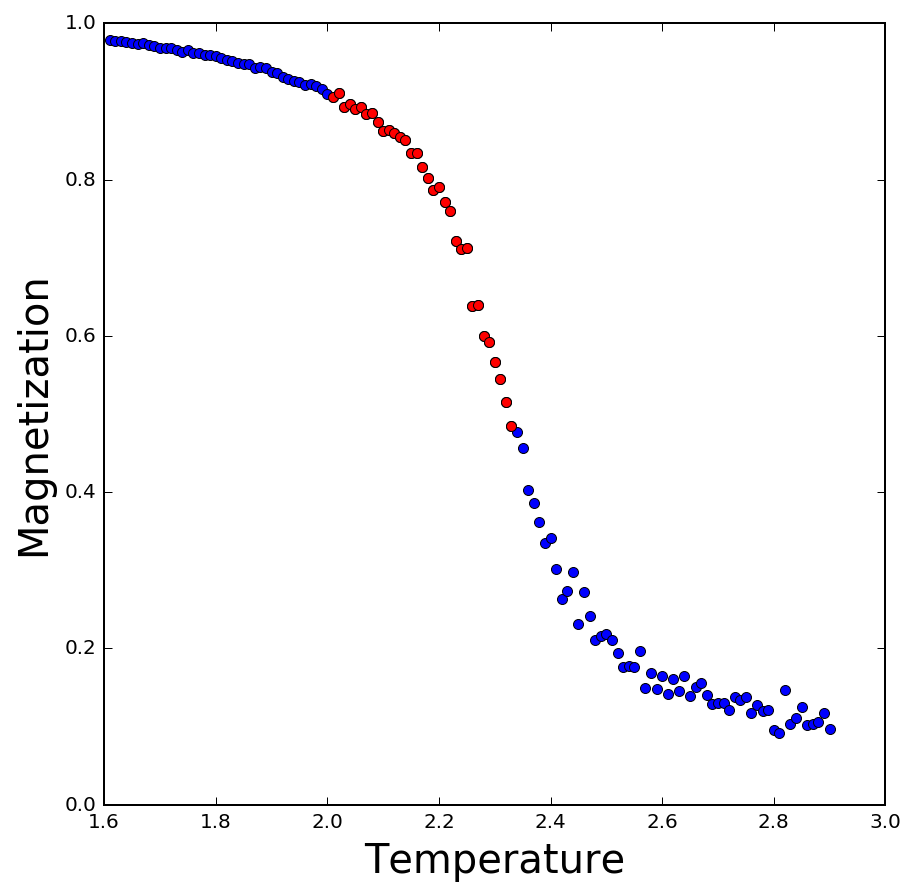

In [474]:
plt.figure(figsize=(7,7)) 
ii = 40
jj = 73
plt.plot(temps, magps_list30, 'bo', markersize = 5)
plt.plot(temps[ii:jj], magps_list30[ii:jj], 'ro', markersize = 5)
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Magnetization", fontsize=20)
plt.show()

In [467]:
coefs_mag, covars_mag = scipy.optimize.curve_fit(power, temps[ii:jj], magps_list30[ii:jj], 
                                                 p0 = [1, 3.1, 0.1], sigma = mag_errors[ii:jj])
coefs_mag, covars_mag
# plt.plot(temps[ii:jj], power(temps[ii:jj], *coefs_mag), 'k--')

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """


(array([ 1.30215   ,  2.3353369 ,  0.17861782]),
 array([[  7.07096658e-04,   5.53891978e-05,   2.58467243e-04],
        [  5.53891978e-05,   1.12725601e-05,   2.26202698e-05],
        [  2.58467243e-04,   2.26202698e-05,   9.62156339e-05]]))

#### susceptibility

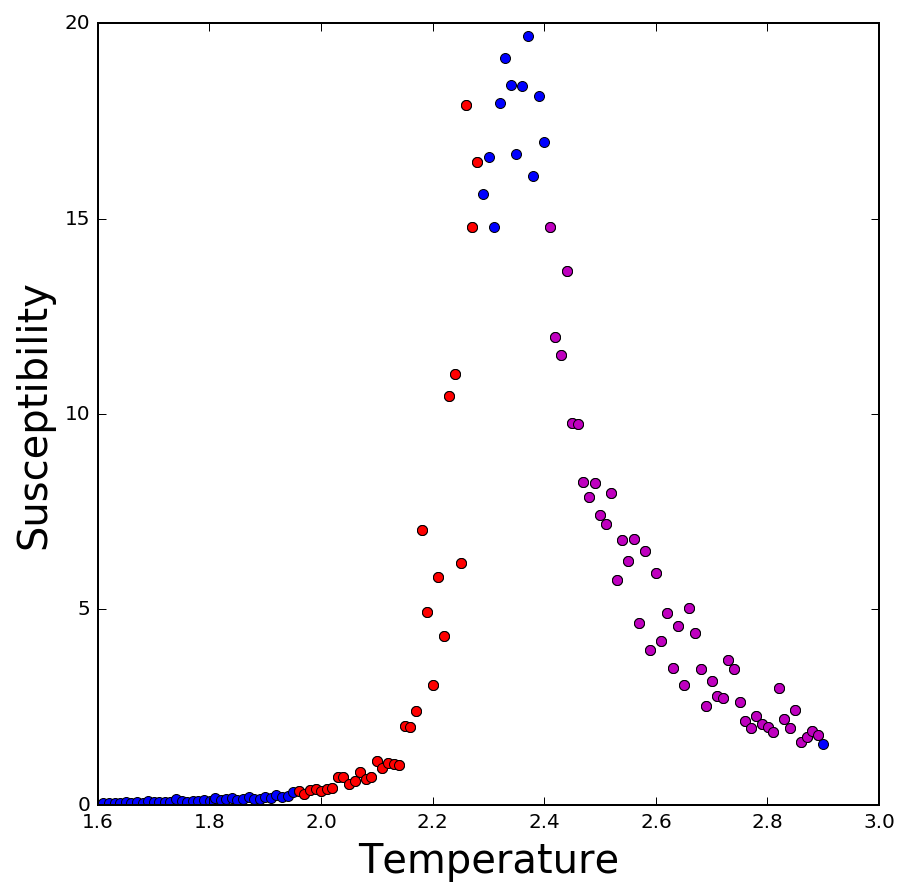

In [517]:
plt.figure(figsize=(7,7)) 
ii = 35
jj = 68
uu = 80
vv = len(mag_sus30)-1
plt.plot(temps, mag_sus30, 'bo', markersize = 5)
plt.plot(temps[ii:jj], mag_sus30[ii:jj], 'ro', markersize = 5)
plt.plot(temps[uu:vv], mag_sus30[uu:vv], 'mo', markersize = 5)
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Susceptibility", fontsize=20)
plt.show()

In [513]:
coefs_sus1, covars_sus1 = scipy.optimize.curve_fit(power, temps[ii:jj], mag_sus30[ii:jj], 
                                                   p0 = [1, 2.4, 1.4], sigma = sus_errors2[ii:jj], maxfev=10000)
coefs_sus1, covars_sus1

(array([  3.88198454e-17,   8.43726241e+01,  -1.48954757e+03]),
 array([[  6.00235282e-29,  -2.39214075e-10,   4.33795513e-09],
        [ -2.39214075e-10,   9.53708588e+08,  -1.72946536e+10],
        [  4.33795513e-09,  -1.72946536e+10,   3.13623120e+11]]))

In [516]:
coefs_sus2, covars_sus2 = scipy.optimize.curve_fit(power, temps[uu:vv], mag_sus30[uu:vv], 
                                                   p0 = [1, 3.0, 1.4], sigma = sus_errors2[uu:vv], maxfev=10000)
coefs_sus2, covars_sus2

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """


(array([ 589918.41237876,    3093.16758601,   13877.84073059]),
 array([[  3.66164711e+12,   4.17416678e+12,   1.87431782e+13],
        [  4.17416678e+12,   4.81708329e+12,   2.16299466e+13],
        [  1.87431782e+13,   2.16299466e+13,   9.71240399e+13]]))

#### specific heat

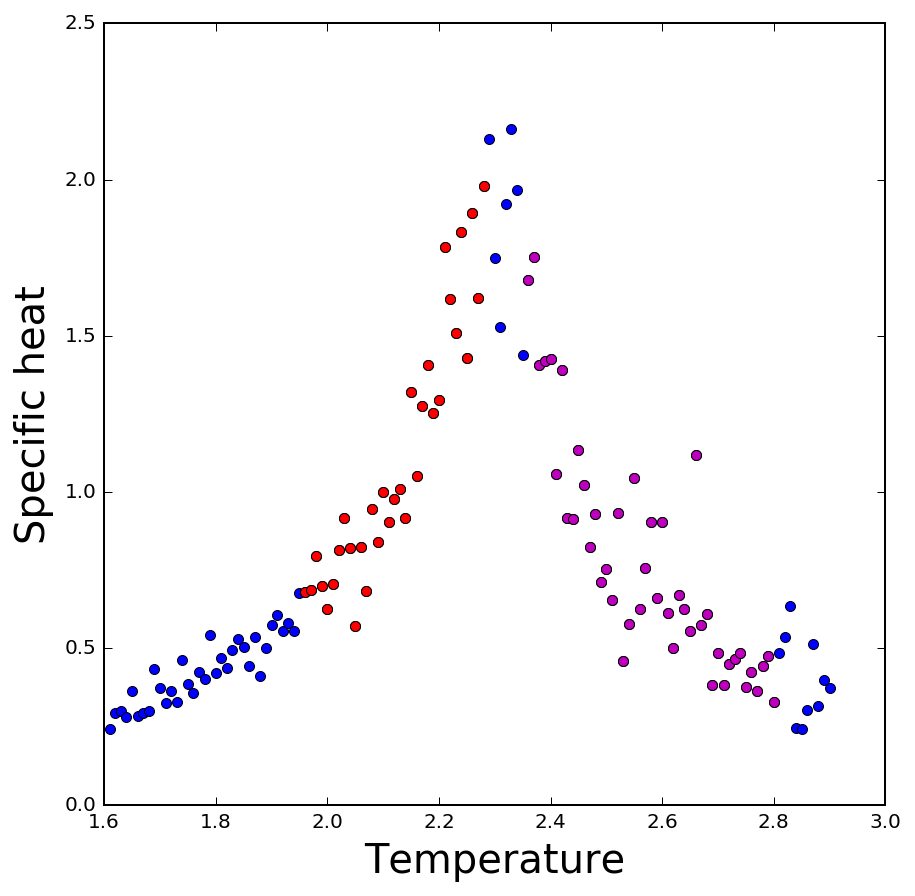

In [520]:
plt.figure(figsize=(7,7)) 
ii = 35
jj = 68
uu = 75
vv = 120
plt.plot(temps, spec_heat30, 'bo', markersize = 5)
plt.plot(temps[ii:jj], spec_heat30[ii:jj], 'ro', markersize = 5)
plt.plot(temps[uu:vv], spec_heat30[uu:vv], 'mo', markersize = 5)
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Specific heat", fontsize=20)
plt.show()

In [521]:
coefs_sh1, covars_sh1 = scipy.optimize.curve_fit(power, temps[ii:jj], spec_heat30[ii:jj], 
                                                   p0 = [1, 2.4, 1.4], sigma = sh_errors[ii:jj], maxfev=10000)
coefs_sh1, covars_sh1

(array([ 0.03026655,  2.82705824, -2.51485135]),
 array([[  4.04016259e-03,  -4.96308040e-02,   1.92497534e-01],
        [ -4.96308040e-02,   6.19362882e-01,  -2.38506559e+00],
        [  1.92497534e-01,  -2.38506559e+00,   9.21473887e+00]]))

In [522]:
coefs_sh2, covars_sh2 = scipy.optimize.curve_fit(power, temps[uu:vv], spec_heat30[uu:vv], 
                                                   p0 = [1, 3.0, 1.4], sigma = sh_errors[uu:vv], maxfev=10000)
coefs_sh2, covars_sh2

(array([  622.4942052 ,   987.73203017,  2617.98414211]),
 array([[  1.12126645e+08,   1.92215505e+10,   5.10824050e+10],
        [  1.92215505e+10,   3.30125984e+12,   8.77327154e+12],
        [  5.10824050e+10,   8.77327154e+12,   2.33154303e+13]]))

#### playing around w/ param_bounds

In [310]:
p0 = np.array([.05, 2.4, -1.75])
param_bounds = ((0, 2.3, -1.75),
                (0.5, 2.5, -1.6))
coefs, covars = scipy.optimize.curve_fit(power, temps[ii_L:ii_R], 
                                         mag_sus8[ii_L:ii_R], 
                                         p0=p0, maxfev=10000, bounds=param_bounds)
coefs, covars

(array([ 0.02237036,  2.35795819, -1.75      ]),
 array([[ 0.00058435, -0.00107147,  0.0139952 ],
        [-0.00107147,  0.00216276, -0.02664512],
        [ 0.0139952 , -0.02664512,  0.34021621]]))

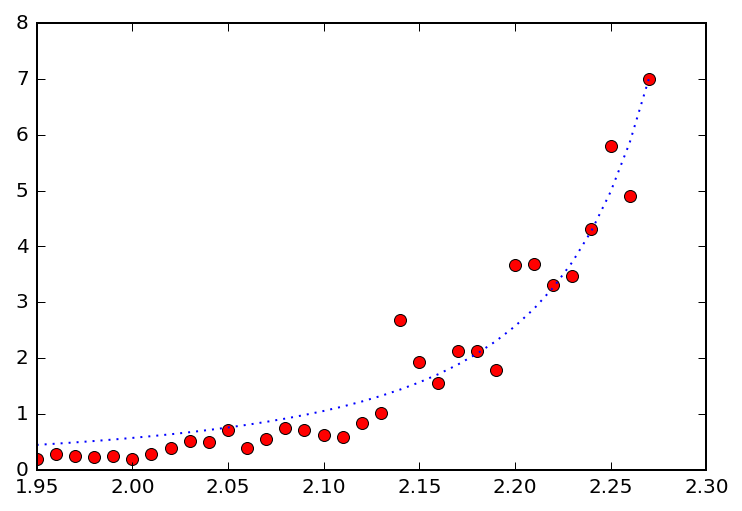

In [306]:
txarr = temps[ii_L:ii_R]
tyarr = power(txarr, *coefs)
plt.plot(txarr, mag_sus8[ii_L:ii_R], 'ro')
plt.plot(txarr, tyarr, 'b:')

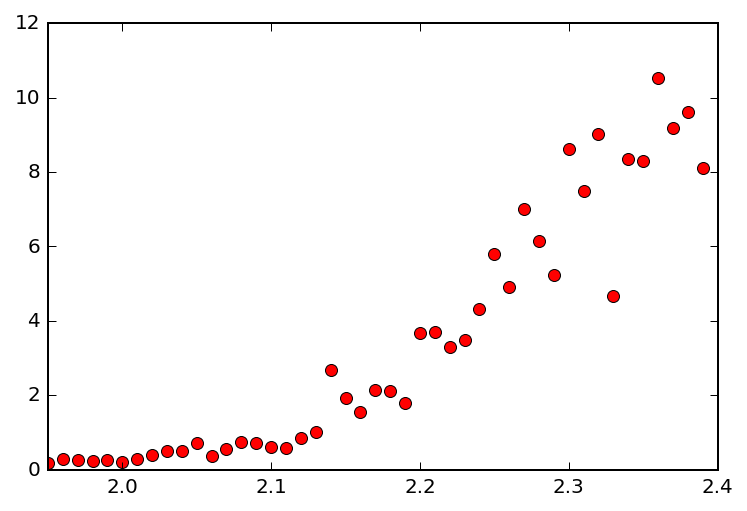

In [219]:
plt.plot(txarr, mag_sus8[ii_L:ii_R], 'ro')

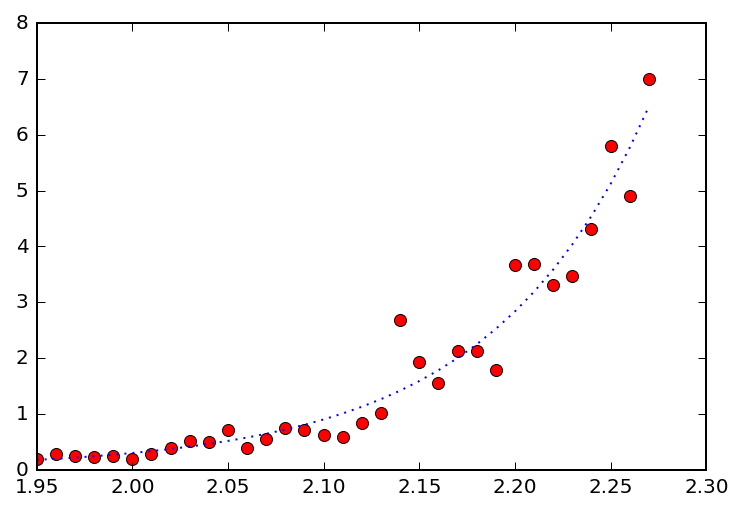

In [299]:
txarr = temps[ii_L:ii_R]
plt.plot(txarr, mag_sus8[ii_L:ii_R], 'ro')
p0 = np.array([.05, 2.4, -1.75])
# p0 = np.array([1.02696430e-06,   4.66377327e+03,  -3.15704357e+04])
p0 = np.array([2.36128678e-08,   4.76679583e+00,  -3.00528471e+01])
tyarr = power(txarr, *p0)
plt.plot(txarr, tyarr, 'b:')